In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.fft import fft, fftfreq, fftshift

# Comparison of parametric and non-parametric calculation of the spectrum of Granger causality 

Refer to <a href='https://www.scielo.br/j/rbef/a/m4LwwHLvk7YwPNMhngNJQwp/?format=pdf&lang=en'>this</a> for the [non-parametric]. Additional reference of the calculation/equation can refers to <a href='https://arxiv.org/abs/q-bio/0608035'>this</a>. Previous work of the [parametric method] is shown in <a href='https://github.com/sajtarius/practice/blob/main/reproduce_granger1.ipynb'>this</a>.

The spectrum of Granger causality ($S_{ij}(\omega)$) can be calculated via the expression: 

$S_{ij}(\omega) = \frac{\left< \tilde{X}_{i}(\omega) \tilde{X}^{*}_{j}(\omega) \right>}{T}$, $i, j \in [1, 2]$, 

such that $T$ is the total duration of the signal, $\tilde{X}_{i}(\omega)$ is the discrete Fourier transform of the signal $X_{i}(t)$ and $\tilde{X}^*_i(\omega)$ is its complex conjugate. 

From the previous <a href='https://github.com/sajtarius/practice/blob/main/reproduce_granger1.ipynb'>code</a>, the spectrum of Granger causality is calculated via the parameter of the (autoregressive model's) equations: 

$\boldsymbol{S(\omega)}=\boldsymbol{H(\omega) \Sigma H^*(\omega)}$   (refer to the <a href='https://github.com/sajtarius/practice/blob/main/reproduce_granger1.ipynb'>code</a> or the <a href='https://arxiv.org/abs/q-bio/0608035'>paper</a> for details). 

This parametric method of calculation require the model to be builded, which is tedious to be achieved for unknown signals.



## Non-parametric calculation
Simulation for 5,000 times with the sampling frequency of 200 Hz for 25 seconds. The noises are generated with the mean of <b>ZERO</b> and the covariance matrix of $\begin{bmatrix}1.0 & 0.0 \\ 0.0 & 1.0 \end{bmatrix}$. 

In [38]:
nmean = np.array([0.0, 0.0])
ncov = np.array([[1.0, 0.0],[0.0, 1.0]]) 
time = 25 #time of the simulation 
fs = 200 #sampling frequency
tdatapoint = time*fs
sim = 5_000 #simulation number
c=0.25

x1 = np.zeros((sim, tdatapoint))
x2 = np.zeros((sim, tdatapoint))

for i in range(0, sim, 1):
    x1noise, x2noise = np.random.multivariate_normal(nmean, ncov, tdatapoint).T
    for j in range(0, tdatapoint, 1): 
        x1[i][j] = 0.55*x1[i][j-1] - 0.8*x1[i][j-2] + c*x2[i][j-1] + x1noise[j]
        x2[i][j] = 0.55*x2[i][j-1] - 0.8*x2[i][j-2] + x2noise[j]

In [51]:
time = 25 #time of the simulation 
fs = 200 #sampling frequency
tdatapoint = time*fs
sim = 5_000 #simulation number
c=0.25

nmean = np.array([0.0, 0.0])
ncov = np.array([[1.0, 0.0],[0.0, 1.0]])
x1noise, x2noise = np.random.multivariate_normal(nmean, ncov, size=(tdatapoint, sim)).T

x1 = np.zeros((sim, tdatapoint))
x2 = np.zeros((sim, tdatapoint))

for t in range(0, tdatapoint, 1):
    x1[:, t] = 0.55*x1[:, t-1] - 0.8*x1[:, t-2] + c*x2[:, t-1] + x1noise[t]
    x2[:, t] = 0.55*x2[:, t-1] - 0.8*x2[:, t-2] + x2noise[t]

In [52]:
fx1 = fft(x1) 
freq_fx1 = fftfreq(tdatapoint, d=1/fs)
fx1_con = np.conj(fx1) 

ans11 = np.mean(fx1*fx1_con, axis=0)/time

In [53]:
fx2 = fft(x2)
freq_fx2 = fftfreq(tdatapoint, d=1/fs)
fx2_con = np.conj(fx2)

ans22 = np.mean(fx2*fx2_con, axis=0)/time

## Result of the non-parametric calculation 

<IPython.core.display.Javascript object>


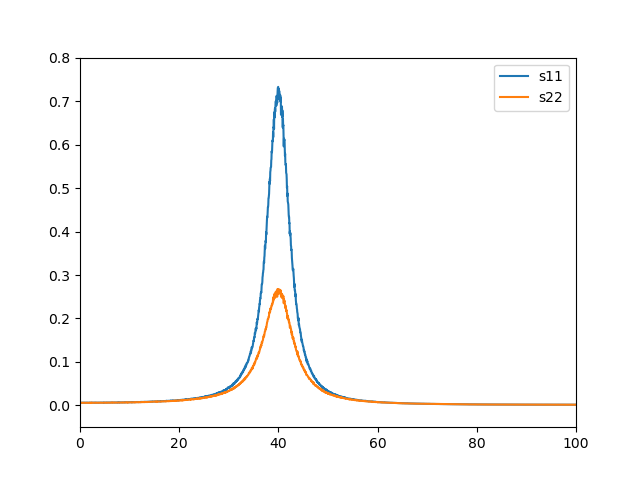

In [55]:
%matplotlib notebook
plt.figure()
plt.plot(fftshift(freq_fx1), np.real(fftshift(ans11))/(np.real(np.max(ans11)+np.max(ans22))), label='s11') 
plt.plot(fftshift(freq_fx2), np.real(fftshift(ans22))/(np.real(np.max(ans11)+np.max(ans22))), label='s22')
plt.legend(loc='best')
plt.xlim(0, 100)
plt.ylim(-0.05, 0.8)
plt.show()

## Parametric calculation 
The method used here is the same as <a href='https://github.com/sajtarius/practice/blob/main/reproduce_granger1.ipynb'>previous work</a>. The condition is the same as the above. 

In [72]:
matCov = np.array([[1.0, 0.0],[0.0, 1.0]])

const = 2j*np.pi
freq = 200 
x = np.linspace(0, freq, int(freq)) 

spectx=[]
specty=[]

for i in x: 
    a = 1 - 0.55*np.exp(-i*const) + 0.8*np.exp(-2*i*const) 
    b = -0.25*np.exp(-i*const)  
    c = 0
    d = 1 - 0.55*np.exp(-i*const) + 0.8*np.exp(-2*i*const) 
    
    matA = np.array([[a,b],[c,d]]) 
    detA = np.linalg.det(matA) 
    
    hxx = d/detA
    hxy = -b/detA
    hyx = -c/detA
    hyy = a/detA
    
    matH = np.array([[hxx, hxy],[hyx, hyy]])
    matHs = np.transpose(np.conjugate(matH)) 
    
    s = np.dot(np.dot(matH, matCov), matHs)
    
    spectx.append(s[0][0])
    specty.append(s[1][1])
    spectxy.append(s[0][1])
    spectyx.append(s[1][0])
    
    #coherence equation 17
    coh = (s[0][1]*s[1][0])/(s[0][0]*s[1][1])
    lol = -np.log(1-coh)
    anscoh.append(coh)
    
    #interdependence
    f = np.log((s[0][0]*s[1][1])/(np.linalg.det(s)))
    inter.append(f)
    
    #causal y to x
    dhxx = hxx + sigma12/sigma11*hxy
    dhxy = hxy 
    dhyx = hyx + sigma12/sigma11*hyy
    dhyy = hyy 
    cyx = np.log((s[0][0])/(dhxx*sigma11*np.conj(dhxx)))
    anscyx.append(cyx)
    
    #causal x to y 
    hhyy = hyy + sigma12/sigma22*hyx
    cxy = np.log((s[1][1])/(hhyy*sigma22*np.conj(hhyy)))
    anscxy.append(cxy)
    
    #instantaneous causal of x and y
    inst_cau = np.log(((dhxx*sigma11*np.conj(dhxx))*(hhyy*sigma22*np.conj(hhyy)))/(np.linalg.det(s)))
    ansinst.append(inst_cau)

## Comparison of the non-parametric method and parametric method 

<IPython.core.display.Javascript object>


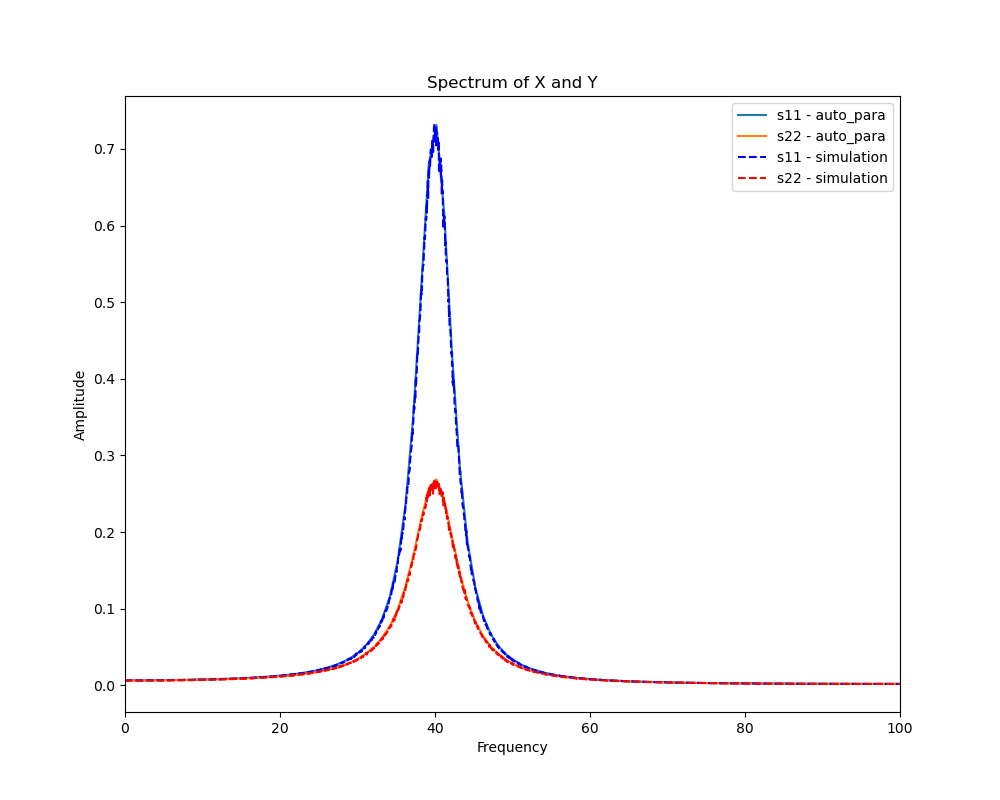

In [77]:
plt.figure(figsize=(10, 8))
plt.plot(x, np.real(np.array(spectx))/(np.real(np.max(spectx)+np.max(specty))), label='s11 - auto_para')
plt.plot(x, np.real(np.array(specty))/(np.real(np.max(spectx)+np.max(specty))), label='s22 - auto_para')
plt.plot(fftshift(freq_fx1), np.real(fftshift(ans11))/(np.real(np.max(ans11)+np.max(ans22))), 'b--', label='s11 - simulation') 
plt.plot(fftshift(freq_fx2), np.real(fftshift(ans22))/(np.real(np.max(ans11)+np.max(ans22))), 'r--', label='s22 - simulation')
plt.legend(loc='best')
plt.xlim(np.min(x), np.max(x)/2)
plt.title('Spectrum of X and Y')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()